In [119]:
import pandas as pd
import numpy as np
import datetime
from collections import defaultdict
import matplotlib.pyplot as plt

The dataset 'marketing_attribution' comprises the following variables:

- fullVisitorId: A unique identifier for each visitor.
- date: The date of the visit.
- visitStartTime: The timestamp of the visit (in POSIX time).
- channelGrouping: The default channel grouping associated with the session.
- utm_source: The traffic source (e.g., Facebook, Google, etc.).
- utm_medium: The traffic medium (e.g., organic, CPC, etc.).
- transactionRevenue: The revenue generated from the transaction.
- transactionId: A unique identifier for each transaction.

Additionally, the variable attribution_window, which represents the period of time during which a publisher can claim that a click or impression led to an install (e.g., 30 days), needs to be derived.

The project objectives are:

- To build a data-driven attribution model for assigning credits to channels related to total conversions.
- To compare the model with the Last Click attribution model.

# Loading Dataset

In [120]:
df = pd.read_csv("/Users/tommipremoli8/Desktop/Data Science for Economics/Materie/Labs/Advanced Analytics in Marketing Lab/Project/Dataset/marketing_attribution.csv")
df

/var/folders/85/5nsqwlmd1xx9qfh9rn8rll2c0000gn/T/ipykernel_44482/1960756689.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/tommipremoli8/Desktop/Data Science for Economics/Materie/Labs/Advanced Analytics in Marketing Lab/Project/Dataset/marketing_attribution.csv")


,fullVisitorId,date,visitId,visitStartTime,channelGrouping,utm_source,utm_medium,transactionRevenue,transactionId
0,9416183380303809617,2016-12-17,1481990278,1481990278,Organic Search,ask,organic,NaN,NaN
1,342964634359205532,2016-12-17,1481999067,1481999067,Organic Search,ask,organic,NaN,NaN
2,294887852901730140,2016-12-17,1481997033,1481997033,Organic Search,ask,organic,NaN,NaN
3,2904105592463883270,2016-12-17,1482038661,1482038661,Display,dfa,cpm,NaN,NaN
4,8140805711484568839,2016-12-17,1482030051,1482030051,Display,dfa,cpm,NaN,NaN
...,...,...,...,...,...,...,...,...,...
903648,3579463718000097974,2016-12-16,1481948294,1481948294,Referral,siliconvalley.about.com,referral,NaN,NaN
903649,840957349706014332,2016-12-16,1481950657,1481950657,Referral,siliconvalley.about.com,referral,NaN,NaN
903650,5185708443902189235,2016-12-16,1481922147,1481922147,Referral,productforums.google.com,referral,NaN,NaN
903651,383774010819667782,2016-12-16,1481901687,1481901687,Referral,productforums.google.com,referral,NaN,NaN


## Dtype Conversion to date formats

In this step, the ‘date’ and ‘visitStartTime’ columns were converted into a datetime format. In the second step, it was specified that the data held were seconds (representing the number of seconds since 1 January 1970 using the Unix format).

In [121]:
df['date'] = pd.to_datetime(df['date'])
df['visitStartTime'] = pd.to_datetime(df['visitStartTime'], unit='s')
df

,fullVisitorId,date,visitId,visitStartTime,channelGrouping,utm_source,utm_medium,transactionRevenue,transactionId
0,9416183380303809617,2016-12-17,1481990278,2016-12-17 15:57:58,Organic Search,ask,organic,NaN,NaN
1,342964634359205532,2016-12-17,1481999067,2016-12-17 18:24:27,Organic Search,ask,organic,NaN,NaN
2,294887852901730140,2016-12-17,1481997033,2016-12-17 17:50:33,Organic Search,ask,organic,NaN,NaN
3,2904105592463883270,2016-12-17,1482038661,2016-12-18 05:24:21,Display,dfa,cpm,NaN,NaN
4,8140805711484568839,2016-12-17,1482030051,2016-12-18 03:00:51,Display,dfa,cpm,NaN,NaN
...,...,...,...,...,...,...,...,...,...
903648,3579463718000097974,2016-12-16,1481948294,2016-12-17 04:18:14,Referral,siliconvalley.about.com,referral,NaN,NaN
903649,840957349706014332,2016-12-16,1481950657,2016-12-17 04:57:37,Referral,siliconvalley.about.com,referral,NaN,NaN
903650,5185708443902189235,2016-12-16,1481922147,2016-12-16 21:02:27,Referral,productforums.google.com,referral,NaN,NaN
903651,383774010819667782,2016-12-16,1481901687,2016-12-16 15:21:27,Referral,productforums.google.com,referral,NaN,NaN


# Define the Attribution Window

In this step, an attribution window of conversions is calculated, that is time intervals that make it possible to evaluate the role played by marketing channels in the conversion process of a customer. For the research, we will use a time period of 30 days, i.e. only visits made by the customer 30 days before the conversion will be taken into account.

In [122]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%y')
df = df.sort_values(['fullVisitorId', 'date'])

df['prev_date'] = df.groupby(['fullVisitorId', 'channelGrouping'])['date'].shift(1)
df['attribution_window'] = (df['date'] - df['prev_date']).dt.days

df['attribution_window'] = df['attribution_window'].fillna(0)

purchases = df[df['transactionId'].notna()]
min_attribution = purchases.groupby(['fullVisitorId', 'channelGrouping'])['attribution_window'].idxmin()
final_df = purchases.loc[min_attribution]

final_df

,fullVisitorId,date,visitId,visitStartTime,channelGrouping,utm_source,utm_medium,transactionRevenue,transactionId,prev_date,attribution_window
325168,213131142648941,2017-04-28,1493419318,2017-04-28 22:41:58,Direct,(direct),(none),39.59,"ORD201704282043,ORD201704282043",NaT,0.0
627265,435324061339869,2016-10-20,1477013621,2016-10-21 01:33:41,Referral,(direct),(none),46.79,"ORD201610201977,ORD201610201977",2016-10-16,4.0
304008,562678147042735,2017-04-24,1493044056,2017-04-24 14:27:36,Referral,(direct),(none),160.31,"ORD201704242024,ORD201704242024,ORD20170424202...",NaT,0.0
672908,670722016498267,2017-07-10,1499709643,2017-07-10 18:00:43,Referral,(direct),(none),43.98,"ORD201707102597,ORD201707102597",NaT,0.0
597310,852801263780322,2017-06-27,1498594489,2017-06-27 20:14:49,Direct,(direct),(none),80.00,"ORD201706272687,ORD201706272687",NaT,0.0
...,...,...,...,...,...,...,...,...,...,...,...
40145,9974232250427988367,2017-01-06,1483725863,2017-01-06 18:04:23,Direct,(direct),(none),996.65,"ORD201701062127,ORD201701062127",NaT,0.0
65202,9974461982959135812,2017-01-19,1484842221,2017-01-19 16:10:21,Referral,(direct),(none),23.99,"ORD201701191769,ORD201701191769",NaT,0.0
569872,9977123823906435841,2016-10-09,1476043400,2016-10-09 20:03:20,Organic Search,(direct),(none),22.19,"ORD201610091325,ORD201610091325",NaT,0.0
35443,9981562221973608723,2017-01-04,1483576938,2017-01-05 00:42:18,Referral,(direct),(none),35.75,"ORD201701042409,ORD201701042409",NaT,0.0


In [123]:
higher_than_30 = final_df[final_df['attribution_window'] > 30]
higher_than_30

,fullVisitorId,date,visitId,visitStartTime,channelGrouping,utm_source,utm_medium,transactionRevenue,transactionId,prev_date,attribution_window
615974,3450834640354121,2016-10-18,1476825602,2016-10-18 21:20:02,Organic Search,google,organic,59.95,"ORD201610182116,ORD201610182116",2016-09-16,32.0
309015,7370307513460988,2017-04-25,1493141304,2017-04-25 17:28:24,Referral,(direct),(none),76.78,"ORD201704252187,ORD201704252187",2017-03-21,35.0
198689,36703532725992752,2017-03-20,1490062298,2017-03-21 02:11:38,Referral,(direct),(none),39.39,"ORD201703202093,ORD201703202093",2017-01-19,60.0
170129,49628940161747998,2017-03-07,1488896284,2017-03-07 14:18:04,Direct,(direct),(none),13.96,"ORD201703071987,ORD201703071987",2017-01-24,42.0
423986,61548717459564263,2017-05-20,1495313366,2017-05-20 20:49:26,Referral,(direct),(none),65.77,"ORD201705201915,ORD201705201915",2017-03-26,55.0
...,...,...,...,...,...,...,...,...,...,...,...
5892,8379398938146461034,2016-12-19,1482191519,2016-12-19 23:51:59,Referral,(direct),(none),49.79,"ORD201612193261,ORD201612193261",2016-11-15,34.0
529611,910504852442385120,2017-06-13,1497395886,2017-06-13 23:18:06,Referral,(direct),(none),379.85,"ORD201706132279,ORD201706132279",2016-10-04,252.0
534669,9672097680372886188,2017-06-14,1497449420,2017-06-14 14:10:20,Referral,(direct),(none),108.41,"ORD201706142398,ORD201706142398",2017-01-18,147.0
35793,9710480501909231921,2017-01-04,1483562473,2017-01-04 20:41:13,Referral,(direct),(none),161.97,"ORD201701042186,ORD201701042186",2016-10-03,93.0


For example, the customer '435324061339869' visited the channel on 16 October 2016 and the transaction took place on 20 October 2016. Thus, the attribution window is equal to 4. 

In [124]:
df[df['fullVisitorId'] == 435324061339869]

,fullVisitorId,date,visitId,visitStartTime,channelGrouping,utm_source,utm_medium,transactionRevenue,transactionId,prev_date,attribution_window
604616,435324061339869,2016-10-16,1476655139,2016-10-16 21:58:59,Referral,(direct),(none),NaN,NaN,NaT,0.0
627265,435324061339869,2016-10-20,1477013621,2016-10-21 01:33:41,Referral,(direct),(none),46.79,"ORD201610201977,ORD201610201977",2016-10-16,4.0
686968,435324061339869,2016-10-30,1477868209,2016-10-30 22:56:49,Referral,(direct),(none),NaN,NaN,2016-10-20,10.0


Next, the final DataFrame is created by deleting all rows in which there is a value in the ‘attribution_window’ column greater than 30.

In [125]:
final_df = final_df[final_df['attribution_window'] <= 30]
final_df

,fullVisitorId,date,visitId,visitStartTime,channelGrouping,utm_source,utm_medium,transactionRevenue,transactionId,prev_date,attribution_window
325168,213131142648941,2017-04-28,1493419318,2017-04-28 22:41:58,Direct,(direct),(none),39.59,"ORD201704282043,ORD201704282043",NaT,0.0
627265,435324061339869,2016-10-20,1477013621,2016-10-21 01:33:41,Referral,(direct),(none),46.79,"ORD201610201977,ORD201610201977",2016-10-16,4.0
304008,562678147042735,2017-04-24,1493044056,2017-04-24 14:27:36,Referral,(direct),(none),160.31,"ORD201704242024,ORD201704242024,ORD20170424202...",NaT,0.0
672908,670722016498267,2017-07-10,1499709643,2017-07-10 18:00:43,Referral,(direct),(none),43.98,"ORD201707102597,ORD201707102597",NaT,0.0
597310,852801263780322,2017-06-27,1498594489,2017-06-27 20:14:49,Direct,(direct),(none),80.00,"ORD201706272687,ORD201706272687",NaT,0.0
...,...,...,...,...,...,...,...,...,...,...,...
40145,9974232250427988367,2017-01-06,1483725863,2017-01-06 18:04:23,Direct,(direct),(none),996.65,"ORD201701062127,ORD201701062127",NaT,0.0
65202,9974461982959135812,2017-01-19,1484842221,2017-01-19 16:10:21,Referral,(direct),(none),23.99,"ORD201701191769,ORD201701191769",NaT,0.0
569872,9977123823906435841,2016-10-09,1476043400,2016-10-09 20:03:20,Organic Search,(direct),(none),22.19,"ORD201610091325,ORD201610091325",NaT,0.0
35443,9981562221973608723,2017-01-04,1483576938,2017-01-05 00:42:18,Referral,(direct),(none),35.75,"ORD201701042409,ORD201701042409",NaT,0.0


# Data Driven Attribution Model (DDA)

The Data Driven Attribution Model is used to identify the amount of credit each of the different marketing channels exploited should receive for having generated a conversion, i.e. a sale. 
To do this, first of all a new column called ‘channelPath’ is created, which represents the complete path of the marketing channels followed by each visitor. This variable contains strings representing the path of the marketing channels for each client. Each visitor is represented only once with his unique marketing channel path. 
After that, the transition probabilities between the various marketing channels in the visitor paths and the removal effects are calculated.
Finally, conversion attributions are computed for each marketing channel based on the removal effects calculated above.



In [126]:
import pandas as pd
from collections import defaultdict
import itertools

# Prepare the data
final_df['channelPath'] = final_df.groupby('fullVisitorId')['channelGrouping'].transform(lambda x: ' > '.join(x))
final_df = final_df.drop_duplicates(subset=['fullVisitorId', 'channelPath'])

# Create the Markov chains
final_df['channelPath'] = final_df['channelPath'].apply(lambda x: ['(start)'] + x.split(' > ') + ['(conversion)'])
transitions = final_df['channelPath'].tolist()

# Calculate transition probabilities
transition_counts = defaultdict(int)
for path in transitions:
    for i in range(len(path) - 1):
        transition_counts[(path[i], path[i+1])] += 1

total_transitions = sum(transition_counts.values())
transition_probs = {k: v / total_transitions for k, v in transition_counts.items()}

# Calculate removal effects
removal_effects = {}
for channel in final_df['channelGrouping'].unique():
    removal_effects[channel] = 0
    for path in transitions:
        if channel in path:
            removal_path = [x for x in path if x != channel]
            removal_prob = 1
            for i in range(len(removal_path) - 1):
                removal_prob *= transition_probs.get((removal_path[i], removal_path[i+1]), 0)
            removal_effects[channel] += removal_prob

# Attribute conversion values
total_removal_effects = sum(removal_effects.values())
attributions = {k: v / total_removal_effects for k, v in removal_effects.items()}


/var/folders/85/5nsqwlmd1xx9qfh9rn8rll2c0000gn/T/ipykernel_44482/1878498457.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['channelPath'] = final_df.groupby('fullVisitorId')['channelGrouping'].transform(lambda x: ' > '.join(x))
/var/folders/85/5nsqwlmd1xx9qfh9rn8rll2c0000gn/T/ipykernel_44482/1878498457.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['channelPath'] = final_df['channelPath'].apply(lambda x: ['(start)'] + x.split(' > ') + ['(conversion)'])


In [127]:
attributions

{'Direct': 0.3531614321946873,
 'Referral': 0.11464345446914838,
 'Organic Search': 0.19215239476661267,
 'Display': 0.12168242944246083,
 'Paid Search': 0.20931782366879997,
 'Social': 0.009042465458290834,
 'Affiliates': 0.0,
 '(Other)': 0.0}

# Last Click Model

The Last Click Model is used to identify the last customer marketing channel in the buyer's journey before conversion (sale). The process is much simpler than the previous one. It is necessary to look at the channel used to carry out the transaction and calculate its weight among the total of the others.

In [128]:
total_conversions = df['transactionId'].nunique()

In [129]:
last_click_weights = df.groupby('channelGrouping')['transactionId'].count() / total_conversions
print(last_click_weights)

channelGrouping
(Other)           0.000087
Affiliates        0.000779
Direct            0.178411
Display           0.012379
Organic Search    0.298044
Paid Search       0.040599
Referral          0.460699
Social            0.009003
Name: transactionId, dtype: float64


# Models Comparison

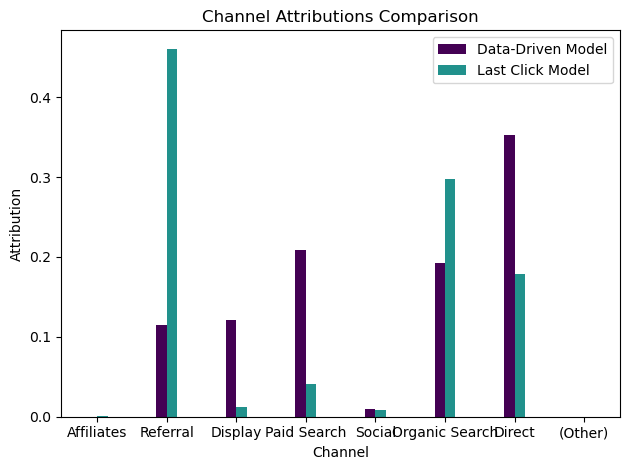

In [140]:
import numpy as np
import matplotlib.pyplot as plt

channels = list(set(list(attributions.keys()) + list(last_click_weights.keys())))
data_driven_attributions = [attributions.get(channel, 0) for channel in channels]
last_click_attributions = [last_click_weights.get(channel, 0) for channel in channels]

x = np.arange(len(channels))
width = 0.15

fig, ax = plt.subplots()

data_driven_color = '#440154'
last_click_color = '#21918c'

rects1 = ax.bar(x - width/2, data_driven_attributions, width, label='Data-Driven Model', color=data_driven_color)
rects2 = ax.bar(x + width/2, last_click_attributions, width, label='Last Click Model', color=last_click_color)

ax.set_xlabel('Channel')
ax.set_ylabel('Attribution')
ax.set_title('Channel Attributions Comparison')
ax.set_xticks(x)
ax.set_xticklabels(channels)
ax.legend()

fig.tight_layout()
plt.show()

# Sava the plot as a PNG file on Desktop in the perfect format
fig.savefig('/Users/tommipremoli8/Desktop/Data Science for Economics/Materie/Labs/Advanced Analytics in Marketing Lab/Project/Attribution_Comparison.png', dpi=300)



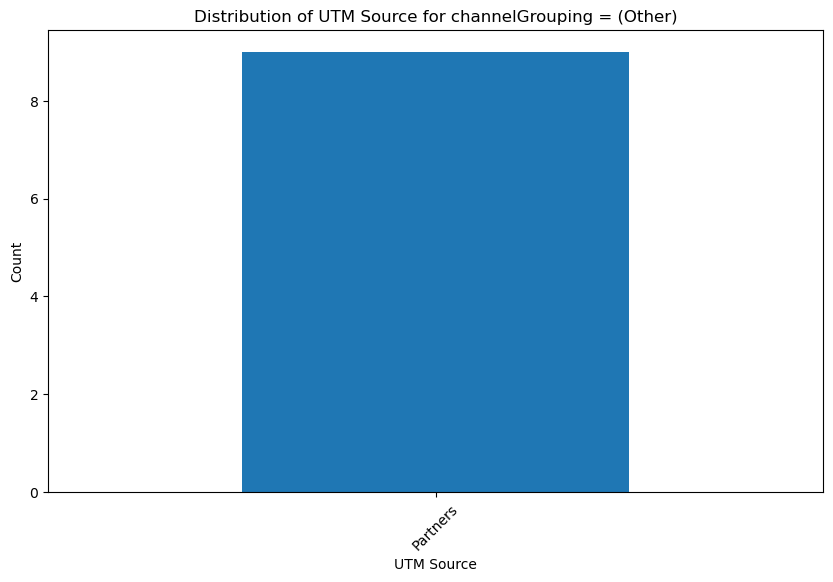

In [131]:
filtered_df = final_df[final_df['channelGrouping'] == 'Affiliates']

plt.figure(figsize=(10, 6))
filtered_df['utm_source'].value_counts().plot(kind='bar')
plt.xlabel('UTM Source')
plt.ylabel('Count')
plt.title('Distribution of UTM Source for channelGrouping = (Other)')
plt.xticks(rotation=45)
plt.show()

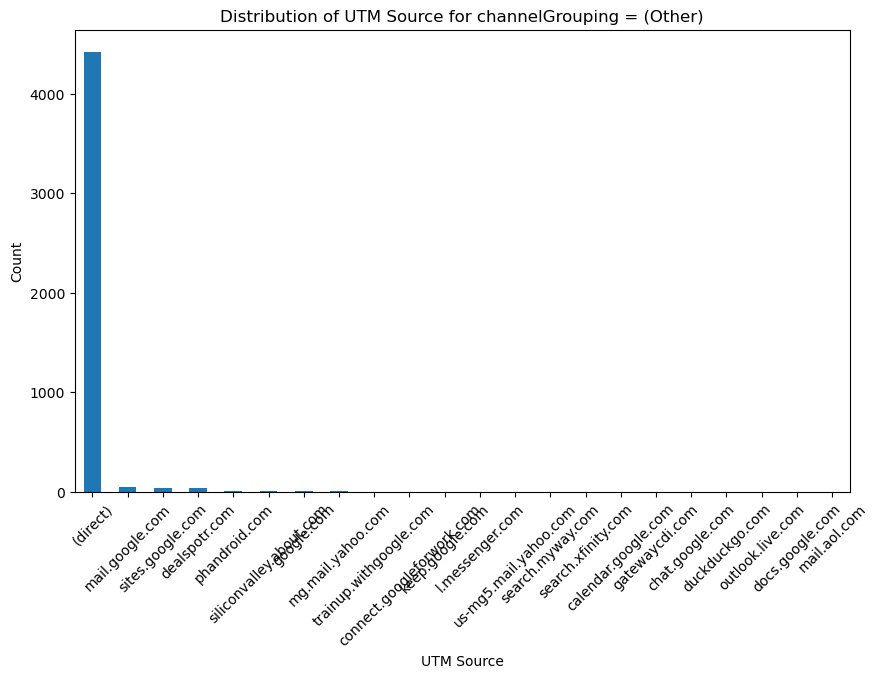

In [132]:
filtered_df = final_df[final_df['channelGrouping'] == 'Referral']

plt.figure(figsize=(10, 6))
filtered_df['utm_source'].value_counts().plot(kind='bar')
plt.xlabel('UTM Source')
plt.ylabel('Count')
plt.title('Distribution of UTM Source for channelGrouping = (Other)')
plt.xticks(rotation=45)
plt.show()

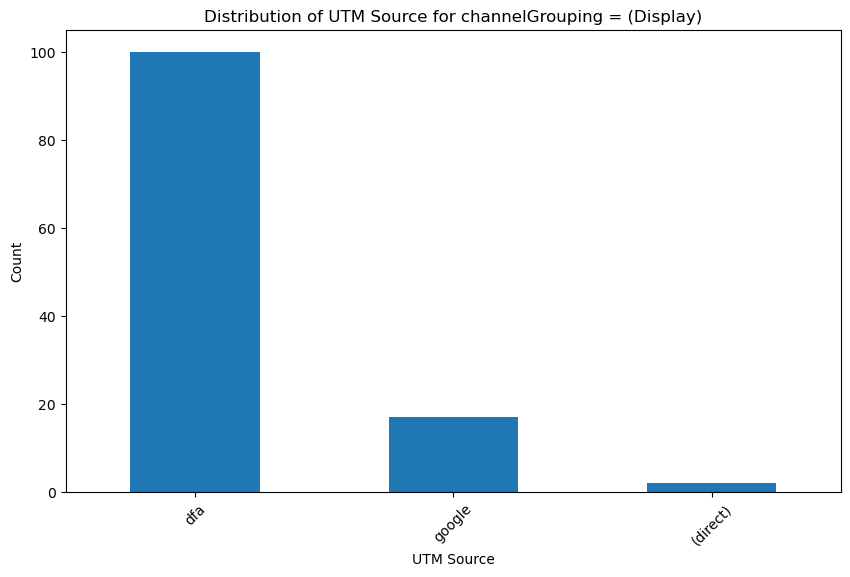

In [133]:
filtered_df = final_df[final_df['channelGrouping'] == 'Display']

plt.figure(figsize=(10, 6))
filtered_df['utm_source'].value_counts().plot(kind='bar')
plt.xlabel('UTM Source')
plt.ylabel('Count')
plt.title('Distribution of UTM Source for channelGrouping = (Display)')
plt.xticks(rotation=45)
plt.show()

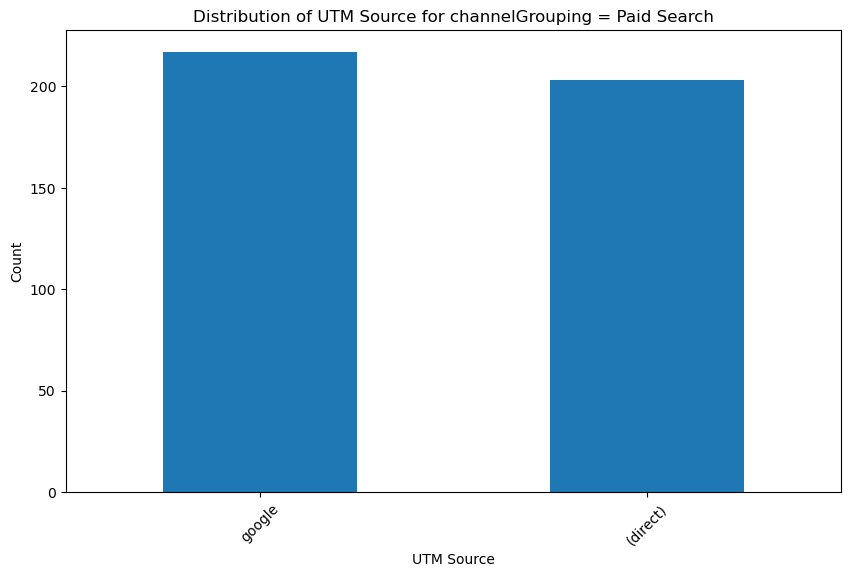

In [134]:
filtered_df = final_df[final_df['channelGrouping'] == 'Paid Search']

plt.figure(figsize=(10, 6))
filtered_df['utm_source'].value_counts().plot(kind='bar')
plt.xlabel('UTM Source')
plt.ylabel('Count')
plt.title('Distribution of UTM Source for channelGrouping = Paid Search')
plt.xticks(rotation=45)
plt.show()

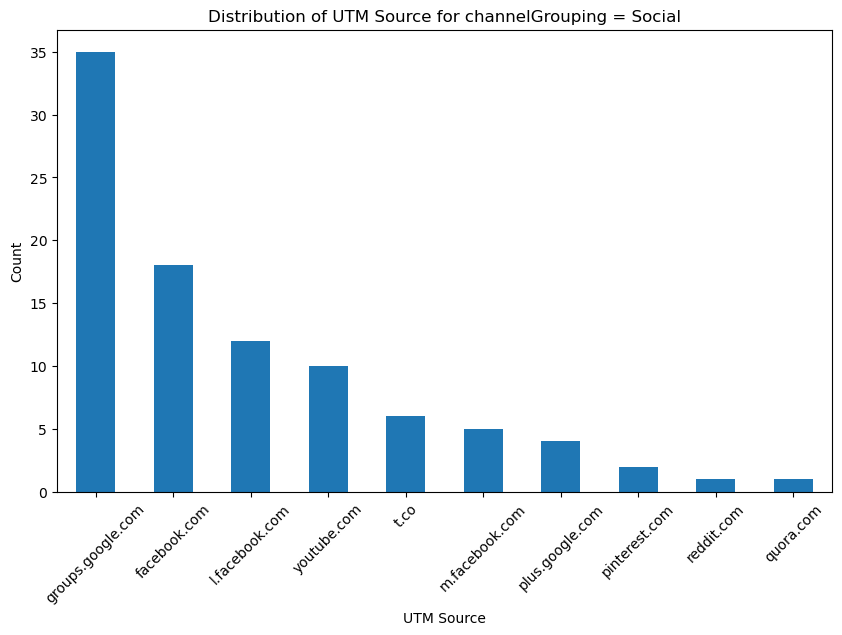

In [135]:
filtered_df = final_df[final_df['channelGrouping'] == 'Social']

plt.figure(figsize=(10, 6))
filtered_df['utm_source'].value_counts().plot(kind='bar')
plt.xlabel('UTM Source')
plt.ylabel('Count')
plt.title('Distribution of UTM Source for channelGrouping = Social')
plt.xticks(rotation=45)
plt.show()

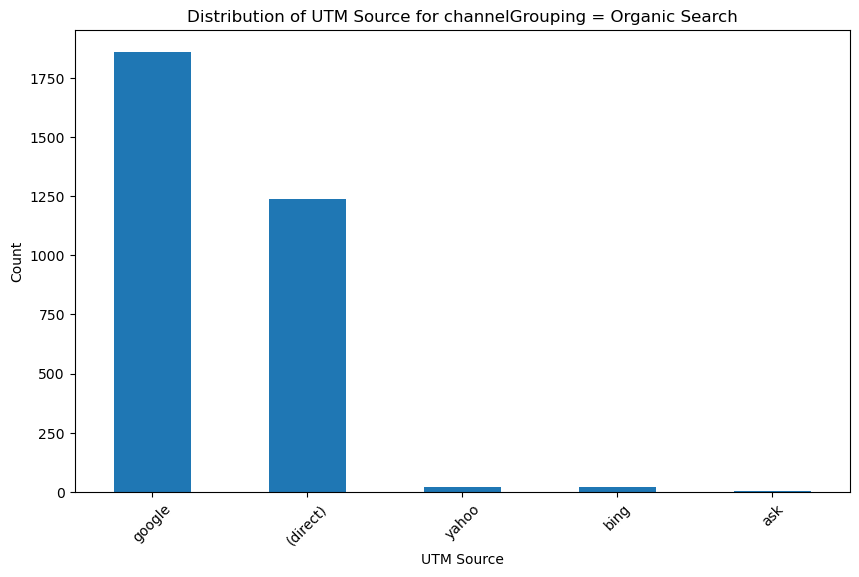

In [136]:
filtered_df = final_df[final_df['channelGrouping'] == 'Organic Search']

plt.figure(figsize=(10, 6))
filtered_df['utm_source'].value_counts().plot(kind='bar')
plt.xlabel('UTM Source')
plt.ylabel('Count')
plt.title('Distribution of UTM Source for channelGrouping = Organic Search')
plt.xticks(rotation=45)
plt.show()